In [4]:
import requests
import datetime
import pytz

import os.path

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.oauth2 import service_account

from git import Repo
import yaml
import re
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import json
from bs4 import BeautifulSoup

In [14]:
def to_eastern(_time):
    return _time.replace(tzinfo=pytz.utc).astimezone(pytz.timezone("US/Eastern"))

def generate_heatmap(data):
    dates = [datetime.datetime.today() - datetime.timedelta(days=i) for i in range(364)]
    while True:
        if dates[-1].weekday() != 6:
            dates.append(dates[-1] - datetime.timedelta(days=1))
        else:
            break

    while True:
        if dates[0].weekday() != 5:
            dates.insert(0, dates[0] + datetime.timedelta(days=1))
        else:
            break

    dates = [d.date() for d in dates]
    contrib_dict = defaultdict(int)
    for ts in data:
        date = to_eastern(datetime.datetime.fromtimestamp(ts)).date()
        start_date = datetime.datetime.strptime('19062022', "%d%m%Y").date()
        if date in dates and start_date < date:
            contrib_dict[date] += 1

    mean_array = [v for v in list(contrib_dict.values()) if v != 0]
    mean = sum(mean_array) / len(mean_array)

    for d in dates:
        if datetime.datetime.today().date() < d:
            contrib_dict[d] = -1
        if d not in contrib_dict.keys():
            contrib_dict[d] = -1

    dates = sorted(dates)
    contrib_dict = dict(sorted(contrib_dict.items()))

    data_array = np.array(list(contrib_dict.values())).reshape((-1, 7))
    dates = np.array(dates).reshape((-1, 7))
    x_ticks = []
    month = dates[0][0].strftime("%b")
    for week in dates:
        month_change = False
        for day in week:
            if day.strftime("%b") != month:
                month_change = True
                month = day.strftime("%b")

        if month_change:
            x_ticks.append(month)
        else:
            x_ticks.append("")

    data_array = np.flipud(data_array.T)
    ax2_labels = ["", "", "", "", "", "", ""]
    for idx, date in enumerate(dates[-1]):
        if date == datetime.date.today():
            ax2_labels[(idx * -1) - 1] = "←"

    # https://stackoverflow.com/questions/69050234/center-specified-tick-labels-for-matplotlibs-pcolomesh-at-the-boxes
    x = np.arange(data_array.shape[1])
    y = np.arange(7)
    c = data_array
    c_base = np.full(c.shape, 3)
    plt.rcParams.update({'font.size': 13,
                         "xtick.color": "dimgray",
                         "ytick.color": "dimgray"})
    fig, ax = plt.subplots(figsize=(14, 2))

    # https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # https://stackoverflow.com/questions/29988241/python-hide-ticks-but-show-tick-labels
    ax.tick_params(axis=u'both', which=u'both', length=0)
    ax.set_yticks(y)
    ax.set_yticklabels(["", "Fri", "", "Wed", "", "Mon", ""])
    ax.set_xticks(x)
    ax.set_xticklabels(x_ticks)
    ax.xaxis.tick_top()

    ax2 = ax.twinx()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax2.tick_params(axis=u'both', which=u'both', length=0)
    ax2.set_yticks(y)
    ax2.set_yticklabels(ax2_labels)
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_ticks)
    ax2.xaxis.tick_top()

    heat_cmap = matplotlib.cm.get_cmap("Oranges").copy()
    heat_cmap.set_under('w')
    plt.pcolormesh(x, y, c, cmap=heat_cmap, edgecolors='w', linewidths=1, vmax=mean * 1.5)
    plt.savefig("heatmap.png", bbox_inches='tight', pad_inches=0)


In [15]:
with open('data/export.xml', 'r') as f:
    data = f.read()

Bs_data = BeautifulSoup(data, "xml")
workouts = Bs_data.find_all('Workout')

In [16]:
workout_dates = []
for w in workouts:
    workout_dates.append(datetime.datetime.strptime(w["creationDate"],"%Y-%m-%d %H:%M:%S %z").timestamp())

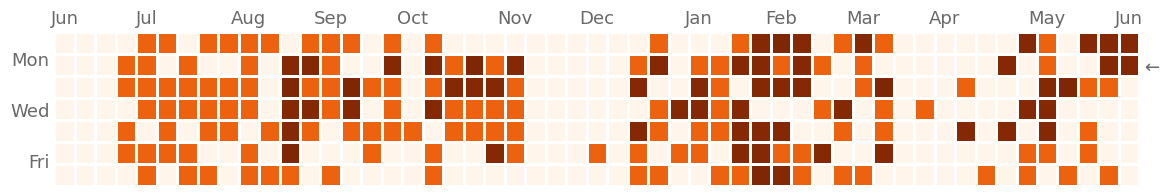

In [17]:
generate_heatmap(workout_dates)